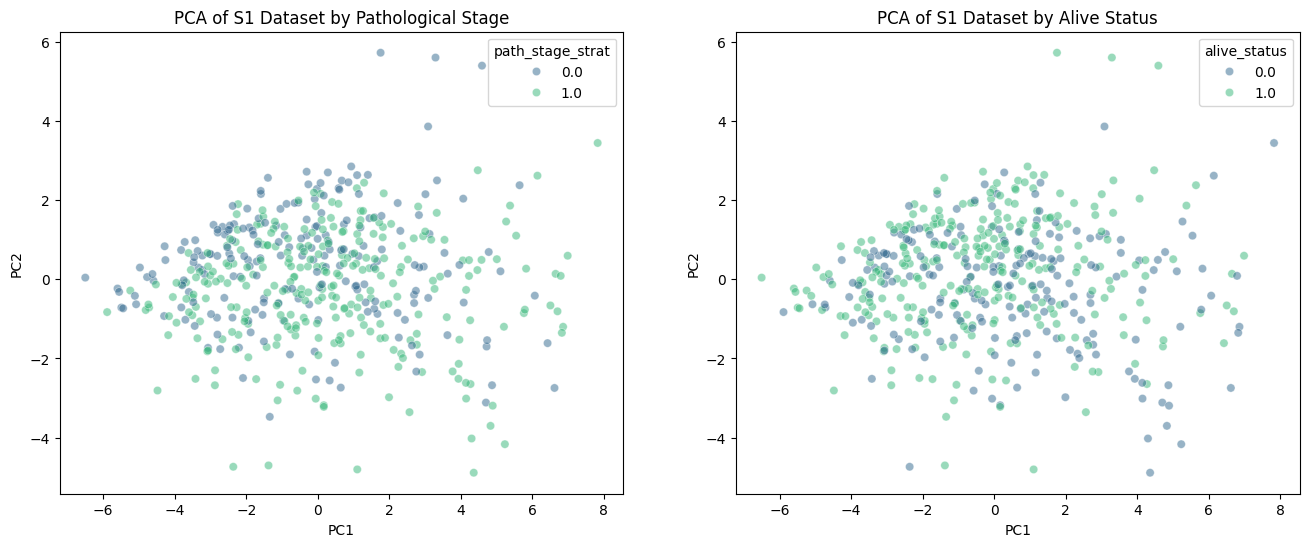

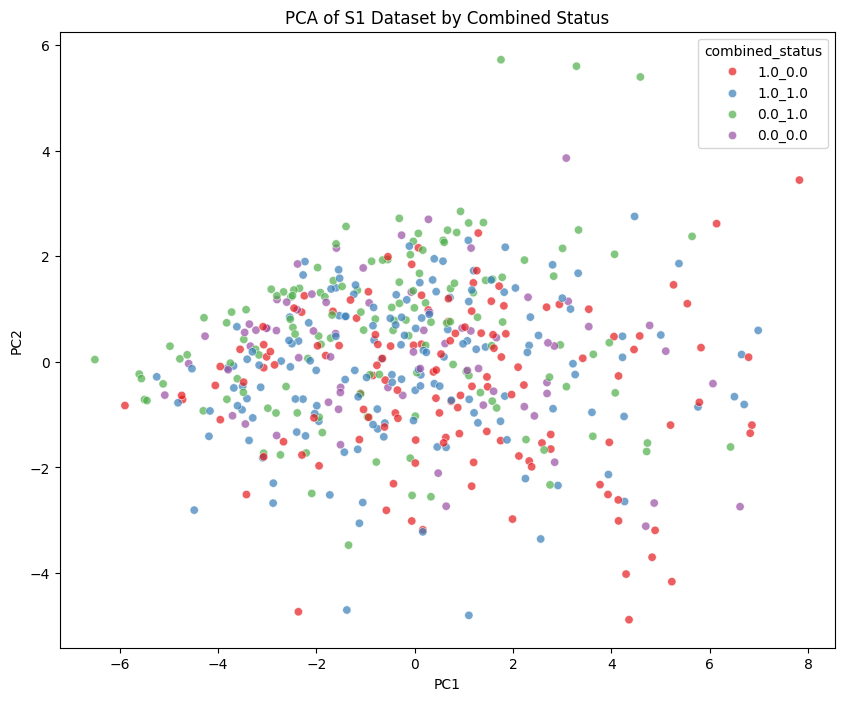

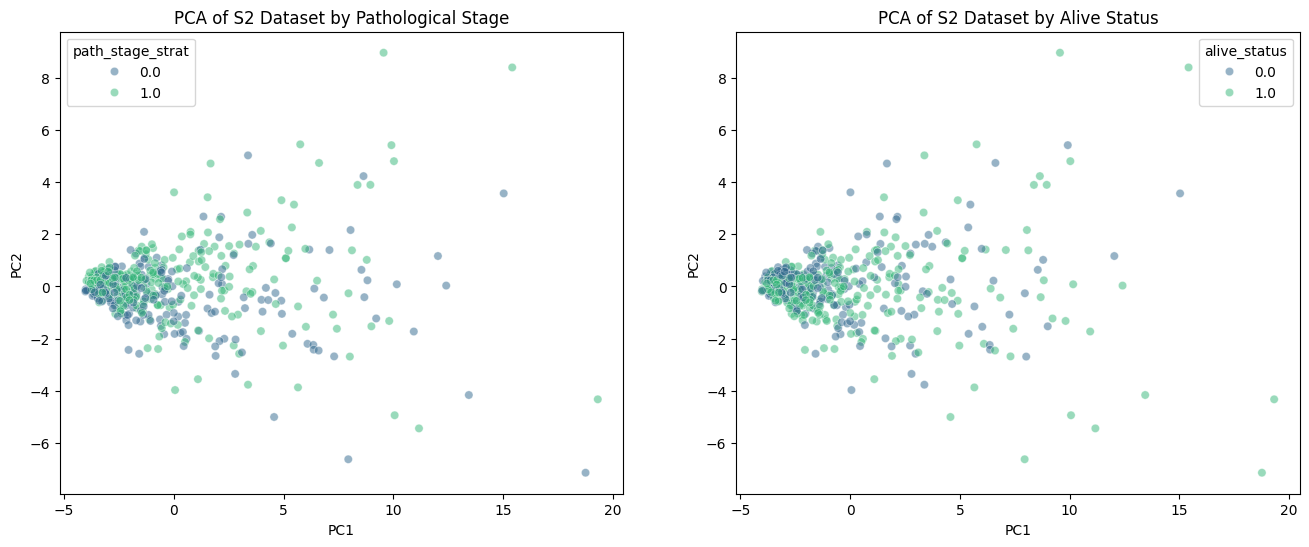

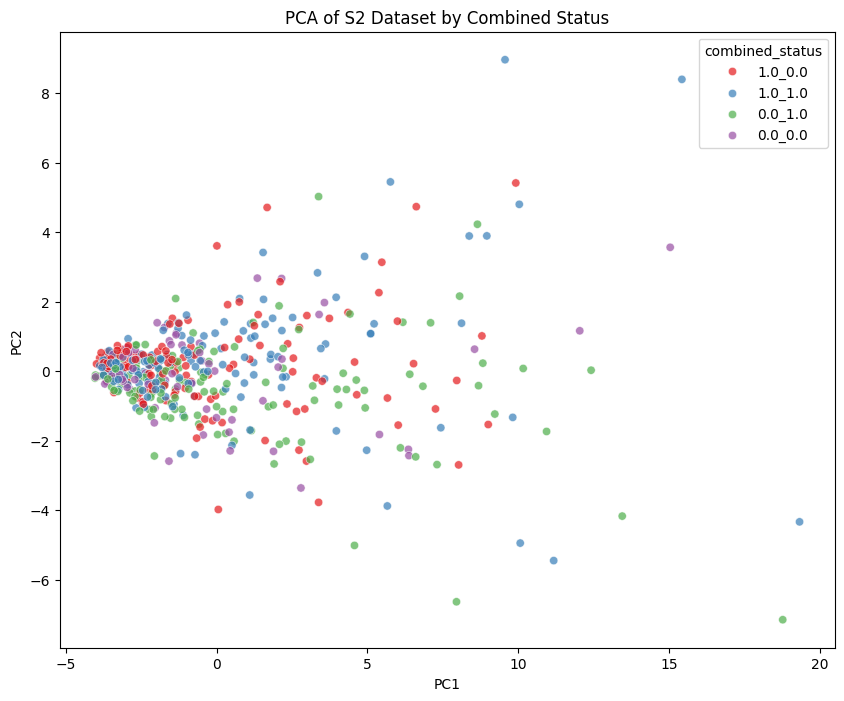

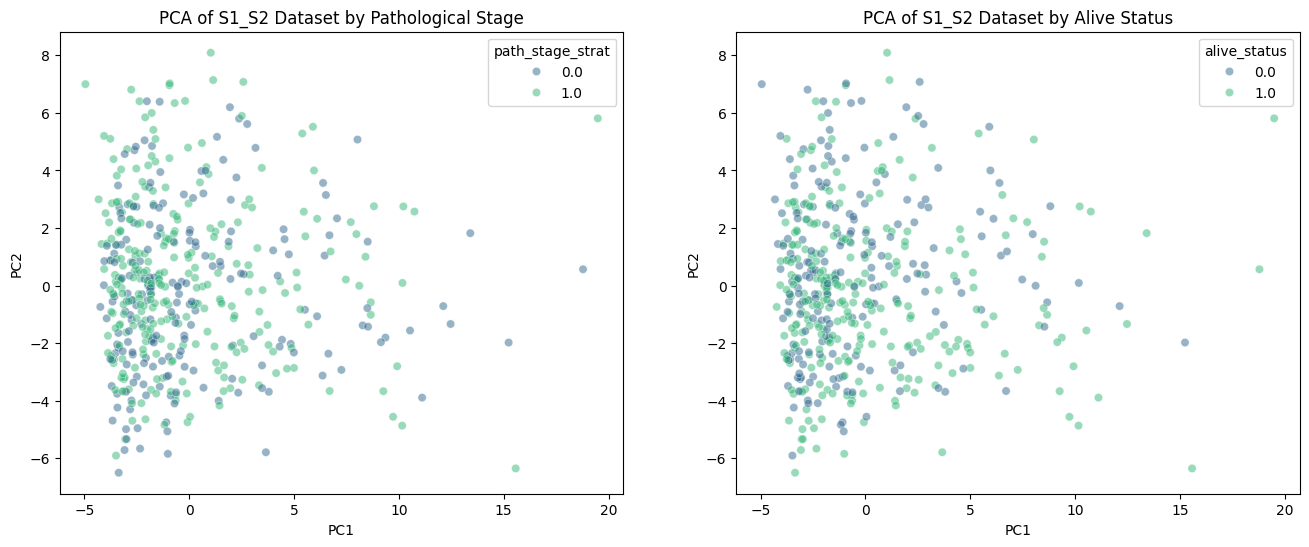

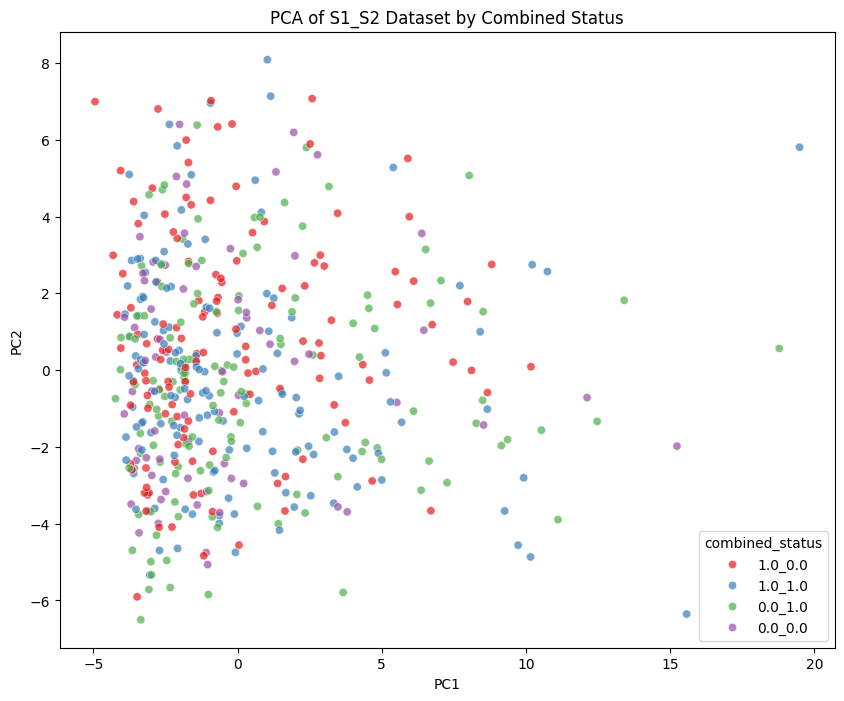

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clinical_df = pd.read_csv('clinical.tsv', sep='\t')
clinical_df['path_stage_strat'] = clinical_df['ajcc_pathologic_stage'].replace("'--", np.NaN).map({'Stage I': 0, 'Stage II': 0, 'Stage III': 0, 'Stage IVA': 1, 'Stage IVB': 1, 'Stage IVC': 1})
conditions = [
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*3),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*3) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*5),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*5) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*10),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*10) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*20),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*20),
    (clinical_df['days_to_death'] == "'--") | (clinical_df['days_to_death'].isna())
]
values = [0, 0, 0, 1, 1, 1, 1]
clinical_df['alive_status'] = np.select(conditions, values)
clinical_df = clinical_df[['case_id', 'path_stage_strat', 'alive_status']]

file_to_case_df = pd.read_csv('file_to_case.tsv', sep='\t')
data_files = ['rnaseq_s1.tsv', 'rnaseq_s2.tsv', 'rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']

for data_file, name in zip(data_files, data_frame_names):
    df = pd.read_csv(data_file, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()
    
    df['combined_status'] = df['path_stage_strat'].astype(str) + "_" + df['alive_status'].astype(str)
    
    X = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
    finalDf = pd.concat([principalDf, df[['path_stage_strat', 'alive_status', 'combined_status']].reset_index(drop=True)], axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(ax=axs[0], x='PC1', y='PC2', hue='path_stage_strat', data=finalDf, palette='viridis', alpha=0.5)
    axs[0].set_title(f'PCA of {name} Dataset by Pathological Stage')
    
    sns.scatterplot(ax=axs[1], x='PC1', y='PC2', hue='alive_status', data=finalDf, palette='viridis', alpha=0.5)
    axs[1].set_title(f'PCA of {name} Dataset by Alive Status')
    
    plt.show()
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='combined_status', data=finalDf, palette='Set1', alpha=0.7)
    plt.title(f'PCA of {name} Dataset by Combined Status')
    plt.show()


In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


data_files = ['rnaseq_s1.tsv', 'rnaseq_s2.tsv', 'rnaseq_s1_s2.tsv']
data_frame_names = ['S1', 'S2', 'S1_S2']

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Results for dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    X = MinMaxScaler().fit_transform(df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status']))
    y = df['alive_status'].values 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, preds)

    print(f"Accuracy for {dataset_name}: {accuracy:.4f}\n")


Results for dataset S1:
Accuracy for S1: 0.5408

Results for dataset S2:
Accuracy for S2: 0.5000

Results for dataset S1_S2:
Accuracy for S1_S2: 0.5714



In [11]:
from keras.models import Model
from keras.layers import Input, Dense

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Processing dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    X = df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status'])
    y = df['alive_status'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    input_img = Input(shape=(X_train_scaled.shape[1],))
    encoded = Dense(20, activation='relu')(input_img)
    encoded = Dense(10, activation='relu')(encoded)
    encoded = Dense(5, activation='relu')(encoded)
    decoded = Dense(10, activation='relu')(encoded)
    decoded = Dense(20, activation='relu')(decoded)
    decoded = Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

    X_train_encoded = encoder.predict(X_train_scaled)
    X_test_encoded = encoder.predict(X_test_scaled)

    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    classifier.fit(X_train_encoded, y_train)

    y_pred = classifier.predict(X_test_encoded)
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {dataset_name}: {overall_accuracy:.4f}\n")

Processing dataset S1:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy for S1: 0.5306

Processing dataset S2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy for S2: 0.4796

Processing dataset S1_S2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy for S1_S2: 0.5204



In [14]:
for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Processing dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    df_alive = df[df['path_stage_strat'] == 1]
    df_deceased = df[df['path_stage_strat'] == 0]

    for df_sub, status in zip([df_alive, df_deceased], ['StageI-III', 'Rest']):
        X = df_sub.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status'])
        y = df_sub['alive_status'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        input_img = Input(shape=(X_train_scaled.shape[1],))
        encoded = Dense(20, activation='relu')(input_img)
        encoded = Dense(10, activation='relu')(encoded)
        encoded = Dense(5, activation='relu')(encoded)
        decoded = Dense(10, activation='relu')(encoded)
        decoded = Dense(20, activation='relu')(decoded)
        decoded = Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded)

        autoencoder = Model(input_img, decoded)
        encoder = Model(input_img, encoded)

        autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

        X_train_encoded = encoder.predict(X_train_scaled)
        X_test_encoded = encoder.predict(X_test_scaled)

        classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        classifier.fit(X_train_encoded, y_train)

        y_pred = classifier.predict(X_test_encoded)
        overall_accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy for {dataset_name} - {status}: {overall_accuracy:.4f}\n")

Processing dataset S1:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy for S1 - StageI-III: 0.4737

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy for S1 - Rest: 0.5854

Processing dataset S2:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy for S2 - StageI-III: 0.4386

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Accuracy for S2 - Rest: 0.6829

Processing dataset S1_S2:
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy for S1_S2 - StageI-III: 0.4386

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Accuracy for S1_S2 - Rest: 0.7073



In [17]:
#status_counts = clinical_df['path_stage_strat'].value_counts().sort_index()
#print(status_counts)


In [18]:
from sklearn.ensemble import RandomForestClassifier

for file_name, dataset_name in zip(data_files, data_frame_names):
    print(f"Processing dataset {dataset_name}:")
    df = pd.read_csv(file_name, sep='\t')
    df = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df = pd.merge(df, clinical_df, on='case_id', how='left').dropna()

    X = df.select_dtypes(include=[np.number]).drop(columns=['path_stage_strat', 'alive_status'])
    y_stage_status = df['path_stage_strat'].values
    y_final = df['alive_status'].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    alive_classifier = RandomForestClassifier(random_state=42)
    alive_classifier.fit(X_scaled, y_stage_status)
    X_alive_status_proba = alive_classifier.predict_proba(X_scaled)

    X_final = np.hstack((X_scaled, X_alive_status_proba))

    X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

    input_img = Input(shape=(X_train_final.shape[1],))
    encoded = Dense(20, activation='relu')(input_img)
    encoded = Dense(10, activation='relu')(encoded)
    encoded = Dense(5, activation='relu')(encoded)
    decoded = Dense(10, activation='relu')(encoded)
    decoded = Dense(20, activation='relu')(decoded)
    decoded = Dense(X_train_final.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_train_final, X_train_final, epochs=50, batch_size=256, validation_split=0.2, verbose=0)

    X_train_encoded = encoder.predict(X_train_final)
    X_test_encoded = encoder.predict(X_test_final)

    classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    classifier.fit(X_train_encoded, y_train_final)

    y_pred = classifier.predict(X_test_encoded)
    overall_accuracy = accuracy_score(y_test_final, y_pred)
    print(f"Accuracy for {dataset_name}: {overall_accuracy:.4f}\n")


Processing dataset S1:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy for S1: 0.5612

Processing dataset S2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Accuracy for S2: 0.5204

Processing dataset S1_S2:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy for S1_S2: 0.5816

